In [909]:
# import lib
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import Dropout

from keras.optimizers import Adam
from keras.models import save_model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

from keras.regularizers import l2
import joblib

import pandas as pd
import numpy as np
import pickle

In [910]:
df = pd.read_csv("data.csv")
df.set_index("date")

,price,warehouse_capacity,truck_capacity
date,,,
2021-01-01,54.42,11,19
2021-01-02,57.53,19,29
2021-01-03,103.36,11,11
2021-01-04,144.76,5,6
2021-01-05,51.06,-5,2
...,...,...,...
2024-12-27,79.10,143,126
2024-12-28,59.52,155,134
2024-12-29,86.44,161,145


In [911]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1461 non-null   object 
 1   price               1461 non-null   float64
 2   warehouse_capacity  1461 non-null   int64  
 3   truck_capacity      1461 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 45.8+ KB


In [912]:
sc = MinMaxScaler(feature_range=(0, 1))

In [913]:
df_scaled = sc.fit_transform(df[['warehouse_capacity', 'truck_capacity']])

In [914]:
# df_scaled = df[['warehouse_capacity', 'truck_capacity']].to_numpy()

In [915]:
df.info

<bound method DataFrame.info of             date   price  warehouse_capacity  truck_capacity
0     2021-01-01   54.42                  11              19
1     2021-01-02   57.53                  19              29
2     2021-01-03  103.36                  11              11
3     2021-01-04  144.76                   5               6
4     2021-01-05   51.06                  -5               2
...          ...     ...                 ...             ...
1456  2024-12-27   79.10                 143             126
1457  2024-12-28   59.52                 155             134
1458  2024-12-29   86.44                 161             145
1459  2024-12-30   69.73                 165             146
1460  2024-12-31  109.07                 154             127

[1461 rows x 4 columns]>

In [916]:
windows = 5
X_train = []
y_train = []

In [917]:
for i in range(windows, len(df)):
    X_train.append(df_scaled[i - windows:i])
    y_train.append(df_scaled[i])

In [918]:
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(1456, 5, 2)
(1456, 2)


In [919]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [920]:
def LSTM_model():
    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    layer_1_units=16
    model.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    
    # # Adding a second LSTM layer and some Dropout regularisation
    layer_2_units=32
    model.add(LSTM(units = layer_2_units))
    model.add(Dropout(0.1))
    
    # Adding the output layer
    model.add(Dense(units = y_train.shape[1]))
    
    # Compiling the LSTM
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return model

In [921]:
model_LSTM = LSTM_model()

early_stopping = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)

In [922]:
# Fitting the RNN to the Training set
epoch_no=100
batch_size=32
history = model_LSTM.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size,
                         validation_data=(X_val, y_val))

Epoch 1/100
41/41 [==============================] - 3s 14ms/step - loss: 0.1306 - val_loss: 0.0207
Epoch 2/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0156 - val_loss: 0.0082
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0101 - val_loss: 0.0046
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.0035
Epoch 5/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0030
Epoch 6/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0030
Epoch 7/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0032
Epoch 8/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0063 - val_loss: 0.0030
Epoch 9/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0029
Epoch 10/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0032
Epoch 11

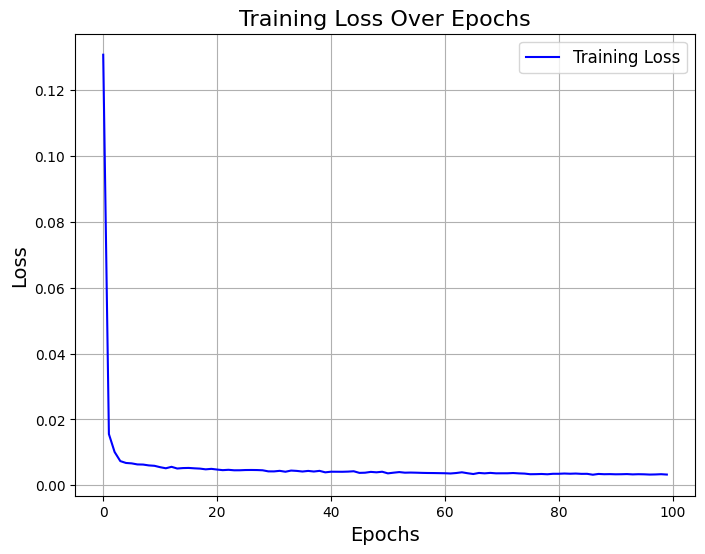

In [923]:
train_loss = history.history['loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [924]:
def RNN_model():
    model = Sequential()
    
    # Adding the first RNN layer and some Dropout regularisation
    layer_1_units = 50
    model.add(SimpleRNN(units=layer_1_units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.1))
    
    # # Adding a second RNN layer and some Dropout regularisation
    # layer_2_units = 32
    # model.add(SimpleRNN(units=layer_2_units))
    # model.add(Dropout(0.1))
    
    # Adding the output layer
    model.add(Dense(units=y_train.shape[1]))
    
    # Compiling the RNN
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [925]:
def GRU_model():
    model = Sequential()
    
    # Adding the first GRU layer and some Dropout regularisation
    layer_1_units = 50
    model.add(GRU(units=layer_1_units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.1))
    
    # # Adding a second GRU layer and some Dropout regularisation
    # model.add(GRU(units=32))
    # model.add(Dropout(0.1))
    
    # Adding the output layer
    model.add(Dense(units=y_train.shape[1]))
    
    # Compiling the GRU
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [926]:
model_rnn = RNN_model()
history = model_rnn.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size,
                         validation_data=(X_val, y_val))

Epoch 1/100
41/41 [==============================] - 1s 4ms/step - loss: 0.0580 - val_loss: 0.0051
Epoch 2/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0107 - val_loss: 0.0042
Epoch 3/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0035
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0033
Epoch 5/100
41/41 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 6/100
41/41 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 7/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 8/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0030
Epoch 9/100
41/41 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0029
Epoch 10/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 11/

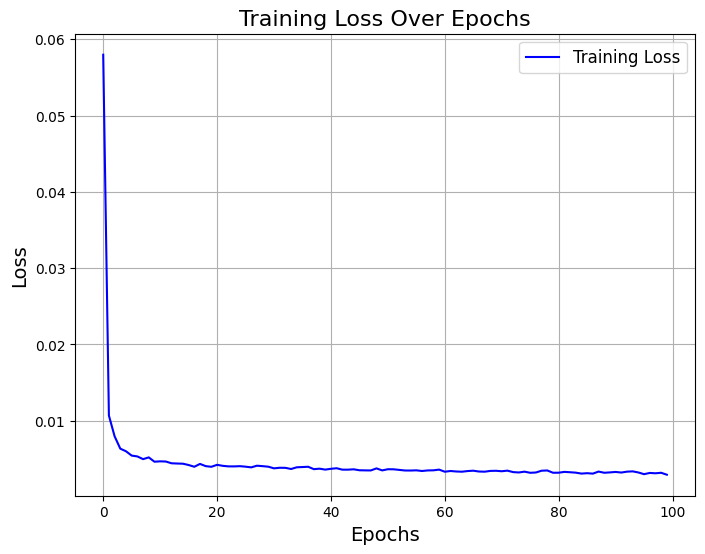

In [927]:
train_loss = history.history['loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [928]:
model_gru = GRU_model()
history = model_gru.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size,
                         validation_data=(X_val, y_val))

Epoch 1/100
41/41 [==============================] - 2s 9ms/step - loss: 0.0632 - val_loss: 0.0075
Epoch 2/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0090 - val_loss: 0.0044
Epoch 3/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0032
Epoch 4/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0029
Epoch 5/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0054 - val_loss: 0.0026
Epoch 6/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0053 - val_loss: 0.0026
Epoch 7/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0051 - val_loss: 0.0026
Epoch 8/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 9/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0027
Epoch 10/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 11/

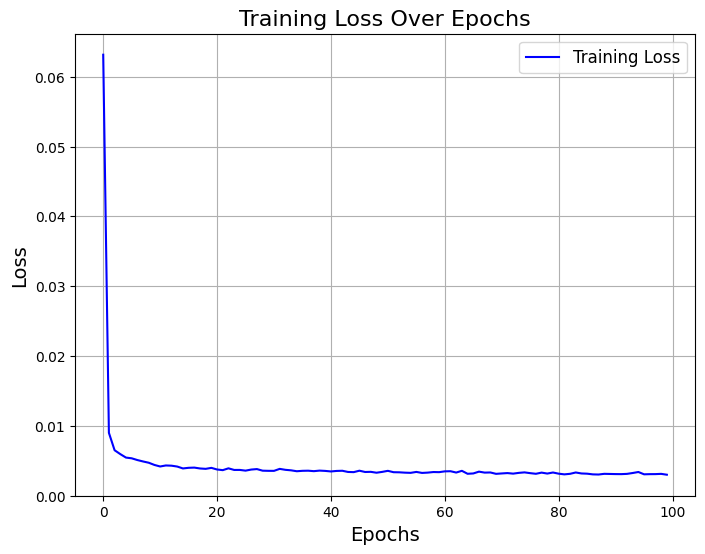

In [929]:
train_loss = history.history['loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [930]:
# save_model
model_LSTM.save('./model_lstm.h5')
model_rnn.save('./model_rnn.h5')
model_gru.save('./model_gru.h5')

/home/long.vk@citigo.id/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [931]:
joblib.dump(sc, 'scaler.pkl')

['scaler.pkl']

In [932]:
type(sc)

sklearn.preprocessing._data.MinMaxScaler

In [933]:
# simple_model_LSTM = simple_LSTM_model()

# early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [934]:
# # Fitting the RNN to the Training set
# epoch_no=64
# batch_size=44
# history = simple_model_LSTM.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size, callbacks=[early_stopping],
#                          validation_data=(X_val, y_val))

In [935]:
# train_loss = history.history['loss']

# plt.figure(figsize=(8, 6))
# plt.plot(train_loss, label='Training Loss', color='blue')
# plt.title('Training Loss Over Epochs', fontsize=16)
# plt.xlabel('Epochs', fontsize=14)
# plt.ylabel('Loss', fontsize=14)
# plt.legend(fontsize=12)
# plt.grid(True)
# plt.show()

In [936]:
# simple_model_LSTM.save('./simple_model_lstm.h5')